In [61]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import os
from tqdm import tqdm
from PIL import Image

In [3]:
# Set random seed for reproducibility
tf.random.set_seed(42)

# Load dataset
data_dir = 'C://Users//sukar//Desktop//Plant Watering and Monitoring System//plant-pathology-2020-fgvc7//images'  # Update with the path to your images directory
metadata = pd.read_csv('C://Users//sukar//Desktop//Plant Watering and Monitoring System//plant-pathology-2020-fgvc7//train.csv')  # Update with the path to your train.csv

In [4]:
# Data preprocessing
image_size = (128, 128)

def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize(image_size)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    return image

In [8]:
metadata['label'] = metadata[['healthy', 'multiple_diseases', 'rust', 'scab']].idxmax(axis=1)

images = []
labels = []

# Loop through the rows
for idx, row in tqdm(metadata.iterrows(), total=metadata.shape[0]):
    img_path = os.path.join(data_dir, row['image_id'] + '.jpg')
    images.append(load_and_preprocess_image(img_path))
    labels.append(row['label'])

images = np.array(images)
labels = np.array(labels)

  0%|          | 0/1821 [00:00<?, ?it/s]

100%|██████████| 1821/1821 [01:25<00:00, 21.36it/s]


In [9]:
# Encode labels
label_encoder = LabelBinarizer()
labels = label_encoder.fit_transform(labels)

In [10]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [12]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator()

In [13]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


c:\Users\sukar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Training
batch_size = 32
epochs = 50

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=val_datagen.flow(X_val, y_val),
    epochs=epochs,
    callbacks=[early_stopping]
)

c:\Users\sukar\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 16s 307ms/step - accuracy: 0.3155 - loss: 1.2919 - val_accuracy: 0.3288 - val_loss: 1.2382
Epoch 2/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 13s 287ms/step - accuracy: 0.3329 - loss: 1.2723 - val_accuracy: 0.3151 - val_loss: 1.2722
Epoch 3/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 17s 373ms/step - accuracy: 0.3456 - loss: 1.2469 - val_accuracy: 0.2795 - val_loss: 1.2413
Epoch 4/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 15s 316ms/step - accuracy: 0.3606 - loss: 1.2478 - val_accuracy: 0.3973 - val_loss: 1.2130
Epoch 5/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.3856 - loss: 1.2324 - val_accuracy: 0.4740 - val_loss: 1.2092
Epoch 6/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 251ms/step - accuracy: 0.4419 - loss: 1.2116 - val_accuracy: 0.5589 - val_loss: 1.1710
Epoch 7/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.4815 - loss: 1.1731 - val_accuracy: 0.5945 - val_loss: 1.0168
Epoch 8/50
46/46 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.5926 - loss: 1.0452 - val_accu

In [15]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_datagen.flow(X_val, y_val), verbose=1)

# Print the accuracy
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - accuracy: 0.8675 - loss: 0.3475
Validation Accuracy: 88.49%


In [18]:
# Save the model
model.save('C://Users//sukar//Desktop//Plant Watering and Monitoring System//plant_disease_model.h5')


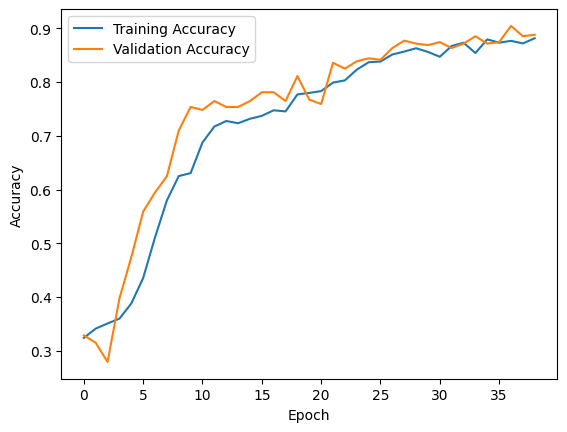

In [19]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [18]:
import tensorflow as tf
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelBinarizer

# Define preprocess_input function
def preprocess_input(image_path):
    image = Image.open(image_path)
    image = image.resize((128, 128))  # Resize to 128x128
    image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Load the trained model
model = tf.keras.models.load_model('plant_disease_model.h5')

# Recreate label_encoder
class_names = ['healthy', 'multiple_diseases', 'rust', 'scub']
label_encoder = LabelBinarizer()
label_encoder.fit(class_names)

# Preprocess an input image
image_path = 'C://Users//sukar//Desktop//Plant Watering and Monitoring System//plant-pathology-2020-fgvc7//images//Test_0.jpg'  # Replace with your image path
preprocessed_image = preprocess_input(image_path)

# Predict
predictions = model.predict(preprocessed_image)

# Decode predictions
predicted_class = np.argmax(predictions, axis=1)[0]
class_labels = label_encoder.classes_
predicted_label = class_labels[predicted_class]

print(f"Predicted Class: {predicted_label}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Predicted Class: rust


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


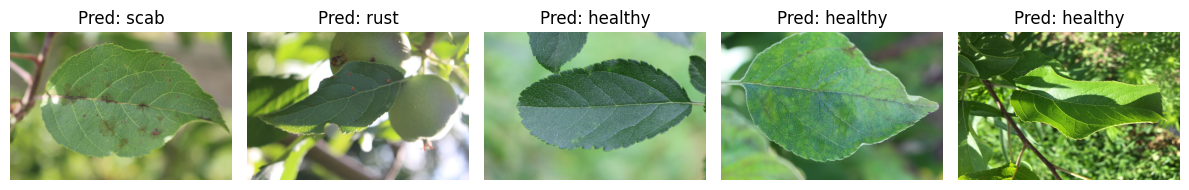

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import random
import os

# Define the image path and model path
data_dir = 'C://Users//sukar//Desktop//Plant Watering and Monitoring System//plant-pathology-2020-fgvc7//images'
model_path = 'plant_disease_model.h5'

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Class labels (update based on your dataset)
class_names = ['healthy', 'multiple_diseases', 'rust', 'scab']

# Function to preprocess image for prediction
def preprocess_input(image_path):
    image = Image.open(image_path)
    image = image.resize((128, 128))
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Load 5 random images from the dataset
image_files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.endswith('.jpg')]
selected_images = random.sample(image_files, 5)

# Plot the images and predictions
plt.figure(figsize=(12, 6))
for i, img_path in enumerate(selected_images):
    img = preprocess_input(img_path)
    prediction = model.predict(img)
    predicted_label = class_names[np.argmax(prediction)]

    # Load and display the original image
    original_img = Image.open(img_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(original_img)
    plt.title(f"Pred: {predicted_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


C:\Users\sukar\AppData\Local\Temp\ipykernel_40184\399048904.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


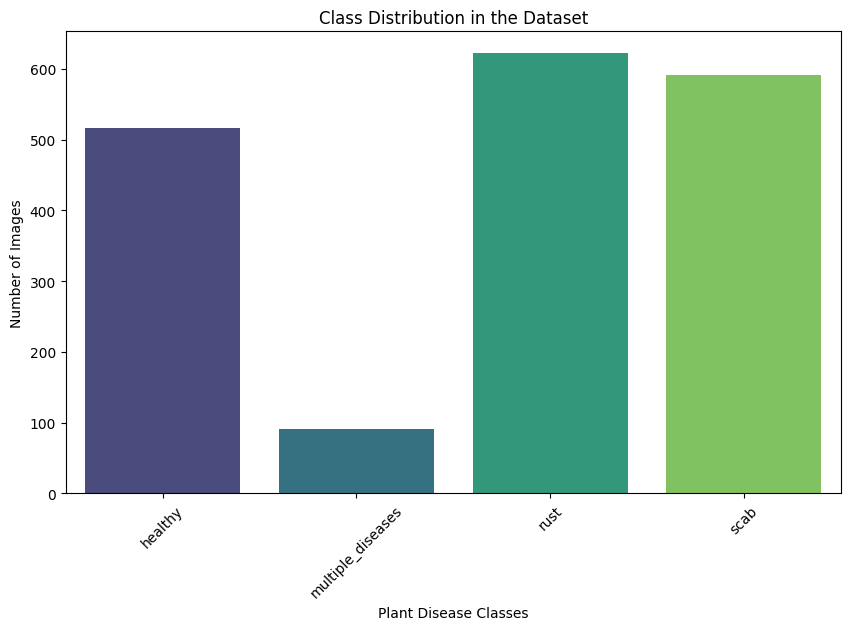

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
csv_path = 'C://Users//sukar//Desktop//Plant Watering and Monitoring System//plant-pathology-2020-fgvc7//train.csv'
df = pd.read_csv(csv_path)

# Count occurrences for each class
class_counts = df.iloc[:, 1:].sum()

# Plot the bar graph
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title('Class Distribution in the Dataset')
plt.xlabel('Plant Disease Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


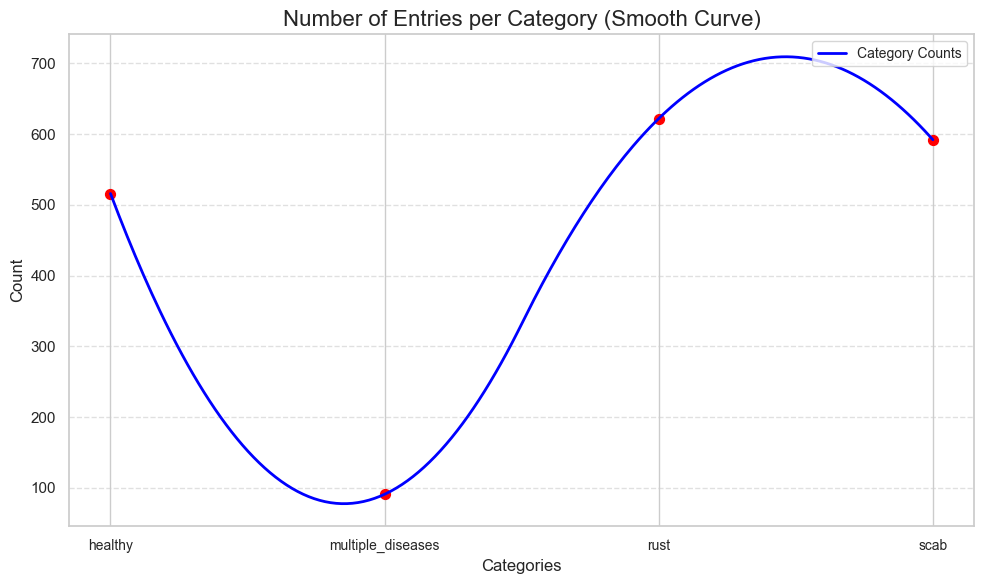

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import make_interp_spline

# Load your dataset
file_path = "C://Users//sukar//Desktop//Plant Watering and Monitoring System//plant-pathology-2020-fgvc7//train.csv"
df = pd.read_csv(file_path)

# Calculate the count of each category
category_counts = df.drop(columns=["image_id"]).sum()

# Prepare data for smooth curves
categories = list(category_counts.index)
counts = list(category_counts.values)

# Create a smooth curve for each category
x = np.arange(len(categories))  # X-axis indices for categories
x_smooth = np.linspace(x.min(), x.max(), 300)  # Smooth interpolation

spl = make_interp_spline(x, counts, k=2)  # Cubic interpolation
y_smooth = spl(x_smooth)

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(x_smooth, y_smooth, label="Category Counts", color='blue', linewidth=2)

# Add markers for each category
for i, count in enumerate(counts):
    plt.scatter(i, count, color='red', s=50)  # Highlight data points

# Customize the plot
plt.xticks(x, categories, fontsize=10)  # Use category names as x-axis labels
plt.title("Number of Entries per Category (Smooth Curve)", fontsize=16)
plt.xlabel("Categories", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.legend(fontsize=10, loc="upper right")

# Display the plot
plt.tight_layout()
plt.show()


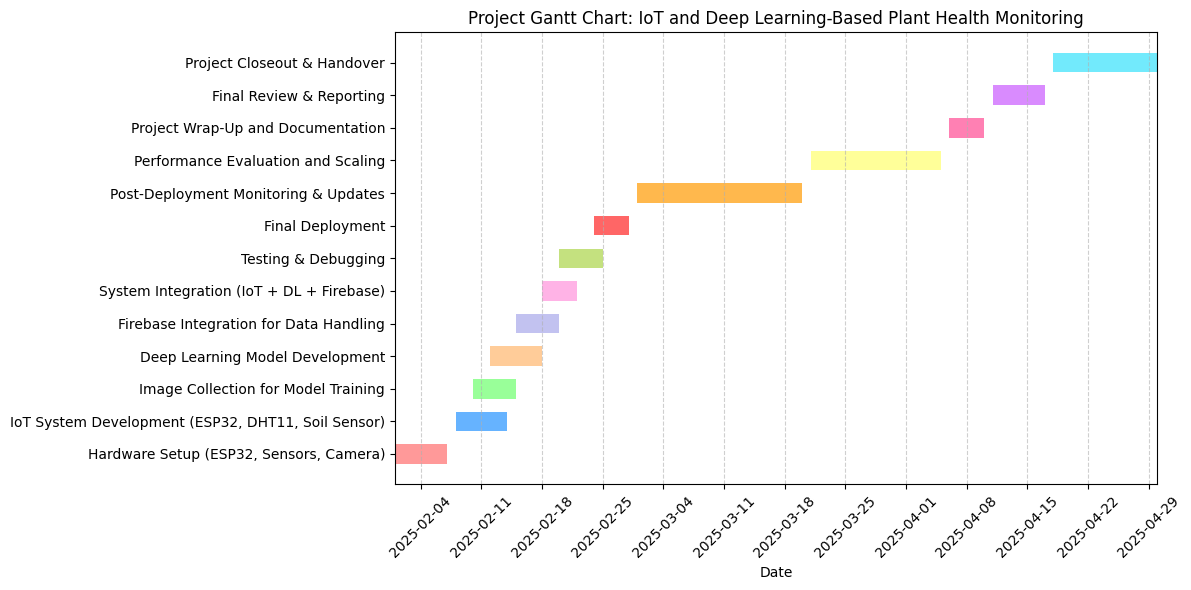

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Define the tasks and their start and end dates
tasks = [
    {"task": "Hardware Setup (ESP32, Sensors, Camera)", "start": "2025-02-01", "end": "2025-02-07"},
    {"task": "IoT System Development (ESP32, DHT11, Soil Sensor)", "start": "2025-02-08", "end": "2025-02-14"},
    {"task": "Image Collection for Model Training", "start": "2025-02-10", "end": "2025-02-15"},
    {"task": "Deep Learning Model Development", "start": "2025-02-12", "end": "2025-02-18"},
    {"task": "Firebase Integration for Data Handling", "start": "2025-02-15", "end": "2025-02-20"},
    {"task": "System Integration (IoT + DL + Firebase)", "start": "2025-02-18", "end": "2025-02-22"},
    {"task": "Testing & Debugging", "start": "2025-02-20", "end": "2025-02-25"},
    {"task": "Final Deployment", "start": "2025-02-24", "end": "2025-02-28"},
    {"task": "Post-Deployment Monitoring & Updates", "start": "2025-03-01", "end": "2025-03-20"},
    {"task": "Performance Evaluation and Scaling", "start": "2025-03-21", "end": "2025-04-05"},
    {"task": "Project Wrap-Up and Documentation", "start": "2025-04-06", "end": "2025-04-10"},
    {"task": "Final Review & Reporting", "start": "2025-04-11", "end": "2025-04-17"},
    {"task": "Project Closeout & Handover", "start": "2025-04-18", "end": "2025-04-30"}
]

# Convert the string dates to datetime objects
for task in tasks:
    task["start"] = datetime.strptime(task["start"], "%Y-%m-%d")
    task["end"] = datetime.strptime(task["end"], "%Y-%m-%d")

# Plot Gantt chart
fig, ax = plt.subplots(figsize=(12, 6))

# Color palette for tasks
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6', '#c4e17f', '#ff6666', '#ffb84d', '#ffff99', '#ff80b3', '#d98bfe', '#72eafc']

# Add tasks to the chart
for i, task in enumerate(tasks):
    ax.barh(i, (task["end"] - task["start"]).days, left=task["start"], height=0.6, color=colors[i % len(colors)], align='center')

# Format x-axis to display dates properly
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.set_xlim(datetime(2025, 2, 1), datetime(2025, 4, 30))  # Set x-axis limits to extend till April 30

plt.xticks(rotation=45)

# Add labels and title
ax.set_xlabel('Date')
ax.set_yticks(range(len(tasks)))
ax.set_yticklabels([task["task"] for task in tasks])
ax.set_title('Project Gantt Chart: IoT and Deep Learning-Based Plant Health Monitoring')

# Customize grid and layout
ax.grid(True, axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()

# Display the chart
plt.show()


In [13]:
import plotly.express as px
import pandas as pd

# Define project phases with start and end dates
data = {
    'Task': [
        'Requirement Analysis', 
        'System Design', 
        'Implementation', 
        'Testing & Validation', 
        'Deployment & Monitoring', 
        'Maintenance & Scaling'
    ],
    'Start': [
        '2025-02-25', 
        '2025-02-28', 
        '2025-03-03', 
        '2025-03-07', 
        '2025-03-10', 
        '2025-03-12'
    ],
    'End': [
        '2025-02-27', 
        '2025-03-02', 
        '2025-03-06', 
        '2025-03-09', 
        '2025-03-11', 
        '2025-03-14'
    ]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create Gantt chart using Plotly
fig = px.timeline(
    df, 
    x_start="Start", 
    x_end="End", 
    y="Task", 
    color="Task",
    title="🚀 Project Development Lifecycle Gantt Chart (Feb 25 - Mar 14, 2025)"
)

# Styling the chart
fig.update_yaxes(autorange="reversed")  # Reverse y-axis for Gantt chart style
fig.update_layout(
    xaxis_title="📅 Timeline",
    yaxis_title="🛠 Development Stages",
    title_font_size=22,
    xaxis=dict(
        tickformat="%b %d", 
        tickangle=-45,
        showgrid=True,
        gridcolor='lightgrey'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgrey'
    ),
    legend_title="📋 Task",
    plot_bgcolor='white',
    bargap=0.2,
    font=dict(
        family="Arial",
        size=12,
        color="#333333"
    )
)

# Highlight weekends
weekends = pd.date_range(start='2025-02-25', end='2025-03-14', freq='W-SAT')
for date in weekends:
    fig.add_vrect(
        x0=date, x1=date + pd.Timedelta(days=1),
        fillcolor="lightblue", opacity=0.2,
        layer="below", line_width=0
    )

# Display the chart
fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed